In [12]:
import pandas as pd
import numpy as np

# from sklearn.linear_model import LinearRegression
# from sklearn import svm
# from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE
# from sklearn.linear_model import Ridge, Lasso
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy.stats import randint

from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, VerboseCallback, DeltaXStopper
from skopt.space import Real, Categorical, Integer
from time import time
from scipy.stats import expon, reciprocal

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from matplotlib import pyplot as plt
import pprint
import warnings
warnings.filterwarnings('ignore')

# Model Tuning: Preprocess to Hyperparameter Tuning
CatBoost Regressor & RandomForest Regressor

<br>

## CatBoost Regressor

<br>

### Result
- Best Cross Validation (StratifiedKFold, n_splits=5) MSE
    - 0.395
- Test MSE
    - 0.423

<br>

### Setting
- Local Outlier Factor
    - `n_neighbors` = 30
    - applied to non-stratified train set (MinMaxScaler)  
- Pipeline

```python
# train set scaler = MinMaxScaler()
OrderedDict([('bagging_temperature', 0.0),
             ('border_count', 112),
             ('depth', 8),
             ('iterations', 918),
             ('l2_leaf_reg', 26),
             ('learning_rate', 0.03284111014718372),
             ('random_strength', 6.959012504143357e-06)])
```

<br>

### Model Performance in Detail
- accuracy (반올림한 예측값과 실제 타깃이 같은 비율)
    - 0.567
- mse_by_target = 각 실제 타깃별로 계산한 MSE

target|accuracy|mse_by_target
-|-|-
3|0.000000|3.901136
4|0.000000|2.166643
5|0.680851|0.237111
6|0.608333|0.252474
7|0.333333|0.725133
8|0.000000|2.394219

<br>

## RandomForest Regressor

<br>

### Result
- Best Cross Validation (StratifiedKFold, n_splits=5) MSE
    - 0.396
- Test MSE
    - 0.484

<br>

### Setting
- Local Outlier Factor
    - `n_neighbors` = 23
    - applied to stratified train set (StandardScaler)  
- Pipeline

```python
# train set scaler = RobustScaler()

OrderedDict([('bootstrap', True),
             ('max_depth', 22),
             ('max_features', 'sqrt'),
             ('min_samples_leaf', 1),
             ('min_samples_split', 2),
             ('n_estimators', 1001)])
```

<br>

### Model Performance in Detail
- accuracy (반올림한 예측값과 실제 타깃이 같은 비율)
    - 0.569
- mse_by_target = 각 실제 타깃별로 계산한 MSE


target|accuracy|mse_by_target
-|-|-
3|0.000000|3.817969
4|0.000000|2.082316
5|0.794643|0.216085
6|0.504854|0.328223
7|0.250000|0.960480
8|0.000000|3.210739



### Load Data

In [67]:
# load data
red = pd.read_csv('./data/winequality-red.csv', sep=';')
red = red.drop_duplicates(keep='last', ignore_index=True)
red.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
1,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
2,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6


In [68]:
RANDOM_SEED = 2021

def split_data(df, seed, stratify=True):
        X = df.drop('quality',axis=1)
        y = df['quality']
        if stratify:
            return train_test_split(X, y,
                                    test_size=0.2,
                                    stratify=y,
                                    shuffle=True,
                                    random_state=seed)
        else:
            return train_test_split(X, y,
                                    test_size=0.2,
                                    shuffle=True,
                                    random_state=seed)

In [69]:
X_train, X_test, y_train, y_test = split_data(red, seed=RANDOM_SEED, stratify=False)
X_train2, X_test2, y_train2, y_test2 = split_data(red, seed=RANDOM_SEED, stratify=True)

# Tuning CatBoostRegressor

In [70]:
def random_grid_search_with_pipeline(Xtr, Xte, ytr, yte, pipe, params, iter_num, seed,
                                     is_not_mute=1, stratify=True):
    if stratify:
        r_grid = RandomizedSearchCV(pipe, params,
                             scoring = 'neg_mean_squared_error',
                             cv=StratifiedKFold(n_splits=5,
                                                  shuffle=True,
                                                  random_state=seed),
                             verbose=is_not_mute, n_jobs=-1, n_iter=iter_num, random_state=seed)
    else:
        r_grid = RandomizedSearchCV(pipe, params,
                             scoring = 'neg_mean_squared_error',
                             cv=KFold(n_splits=5,
                                      shuffle=True,
                                      random_state=seed),
                             verbose=is_not_mute, n_jobs=-1, n_iter=iter_num, random_state=seed)
    
    r_grid.fit(Xtr, ytr)
    if is_not_mute:
        print(r_grid.best_params_)
        print('Best CV MSE', -1 * r_grid.best_score_)
        print('Test MSE', np.mean(np.square(r_grid.predict(Xte) - yte)))
    return r_grid

In [71]:
# LOF tuning
def LOF_tuning(df, param_dict, pipe, pipe_param_dict, stratify = True, seed=RANDOM_SEED):
    
    Xtrain, Xtest, ytrain, ytest = split_data(df, seed=seed, stratify=stratify)
    
    # normalize data
    X_scaler = param_dict['scaler']
    X_train_std = X_scaler.fit_transform(Xtrain)
    X_test_std = X_scaler.transform(Xtest)
    
    best_cv_score = 100
    best_n_neighbors = 0
    best_grid = ''
    best_dataset = []
    
    # outlier removal using Local Outlier Factor
    n_neighbors_list = param_dict['n_neighbors']
    for i, nn in enumerate(n_neighbors_list):
        lof = LocalOutlierFactor(n_neighbors=nn)
        y_pred_std = lof.fit_predict(X_train_std)
        outlier_idx = np.where(y_pred_std==-1)[0]
        
        X_train_lof, X_test_lof, y_train_lof, y_test_lof = split_data(df.drop(outlier_idx),
                                                                     seed=seed,
                                                                     stratify=stratify)        
        rand_grid = random_grid_search_with_pipeline(X_train_lof,
                                                     X_test_lof,
                                                     y_train_lof,
                                                     y_test_lof,
                                                     pipe,
                                                     pipe_param_dict,
                                                     iter_num=1000,
                                                     seed=seed,
                                                     is_not_mute=0,
                                                     stratify=stratify)
    
        if (-1 * rand_grid.best_score_) < best_cv_score:
            best_cv_score = -1 * rand_grid.best_score_
            best_grid = rand_grid
            best_n_neighbors = nn
            best_dataset = X_train_lof, X_test_lof, y_train_lof, y_test_lof
            print(f'update: {best_cv_score}')
        
        if i % 10 == 0:
            print('/', end=' ')
        
    return best_dataset, best_n_neighbors

In [72]:
pipe_base = Pipeline([
                ('scale', MinMaxScaler()),
                ('regressor', CatBoostRegressor())
                ])

param_base = [              
              {'regressor': [CatBoostRegressor()],
               'regressor__loss_function' : ['RMSE'],
               'regressor__silent':[True],
                'regressor__random_state':[RANDOM_SEED],
               'scale':[MinMaxScaler(), StandardScaler(), RobustScaler()],
              }
             ]

In [73]:
lof_param_mms = {'scaler':MinMaxScaler(),
            'n_neighbors':range(10, 40)}
best_lof_data_mms, best_neighbor_param_mms = LOF_tuning(red, lof_param_mms,
                                                        pipe_base, param_base,
                                                        stratify=False)

update: 0.43274947723274126
/ update: 0.4224019349333469
update: 0.4134534329460271
/ update: 0.40446484347330935
/ 

In [14]:
lof_param_ss = {'scaler':StandardScaler(),
            'n_neighbors':range(10, 40)}
best_lof_data_ss, best_neighbor_param_ss = LOF_tuning(red, lof_param_ss,
                                                      pipe_base, param_base,
                                                      stratify=False)

update: 0.4336457575825608
/ update: 0.42900641837758685
update: 0.42631952771922715
update: 0.4168671702102279
update: 0.41003106528933053
/ update: 0.40497030084265234
/ 

In [15]:
lof_param_rs = {'scaler':RobustScaler(),
            'n_neighbors':range(10, 40)}
best_lof_data_rs, best_neighbor_param_rs = LOF_tuning(red, lof_param_rs,
                                                      pipe_base, param_base,
                                                      stratify=False)

update: 0.4410327844659901
/ update: 0.4389211206853398
update: 0.4350800275736895
update: 0.4183417887438073
update: 0.4182084541760701
/ update: 0.41093235501256214
/ 

In [75]:
# best n_neighbors = 30
print(best_neighbor_param_mms)
X_train_lof, X_test_lof, y_train_lof, y_test_lof = best_lof_data_mms

30


### Pipeline & Model Tuning

In [76]:
# original data (no LOF)
# scaler opt only
pipe_no_prep_opt = Pipeline([
                ('scale', RobustScaler()),
                ('regressor', CatBoostRegressor())
                ])

param_no_prep_opt = [              
              {'regressor': [CatBoostRegressor()],
               'regressor__silent':[True],
                'regressor__random_state':[RANDOM_SEED],
               'regressor__loss_function' : ['RMSE'],
               'scale':[RobustScaler(), StandardScaler(), MinMaxScaler()],
              }
             ]

r_grd_no_prep_opt0 = random_grid_search_with_pipeline(X_train, X_test, y_train, y_test,
                                pipe_no_prep_opt, param_no_prep_opt, iter_num=100,
                                                     seed=RANDOM_SEED,
                                                    stratify=False)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   10.7s finished


{'scale': MinMaxScaler(copy=True, feature_range=(0, 1)), 'regressor__silent': True, 'regressor__random_state': 2021, 'regressor__loss_function': 'RMSE', 'regressor': <catboost.core.CatBoostRegressor object at 0x1a22448090>}
Best CV MSE 0.45694873485709797
Test MSE 0.37965734832707604


In [77]:
# scaler opt only
pipe_no_prep_opt = Pipeline([
                ('scale', RobustScaler()),
                ('regressor', CatBoostRegressor())
                ])

param_no_prep_opt = [              
              {'regressor': [CatBoostRegressor()],
               'regressor__silent':[True],
                'regressor__random_state':[RANDOM_SEED],
               'regressor__loss_function' : ['RMSE'],
               'scale':[RobustScaler(), StandardScaler(), MinMaxScaler()],
              }
             ]

r_grd_no_prep_opt = random_grid_search_with_pipeline(X_train_lof, X_test_lof, y_train_lof, y_test_lof,
                                pipe_no_prep_opt, param_no_prep_opt, iter_num=100,
                                                     seed=RANDOM_SEED,
                                                    stratify=False)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   10.5s finished


{'scale': StandardScaler(copy=True, with_mean=True, with_std=True), 'regressor__silent': True, 'regressor__random_state': 2021, 'regressor__loss_function': 'RMSE', 'regressor': <catboost.core.CatBoostRegressor object at 0x1a21a7f510>}
Best CV MSE 0.40446484347330935
Test MSE 0.4400908780717685


Text(0.5, 0, 'CatBoost Feature Importance')

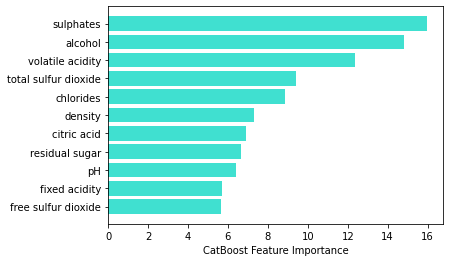

In [78]:
mms = MinMaxScaler()
X_train_lof_mms = mms.fit_transform(X_train_lof)
X_test_lof_mms = mms.transform(X_test_lof)

cbr = CatBoostRegressor(silent=True, random_state=RANDOM_SEED, loss_function='RMSE')
cbr.fit(X_train_lof_mms, y_train_lof)

sorted_feature_importance = cbr.feature_importances_.argsort()
plt.barh(red.drop('quality', axis=1).columns[sorted_feature_importance], 
        cbr.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

### BayesianSearchCV -> 모델 하이퍼파라미터 튜닝

In [79]:
# Reporting util for different optimizers
def report_perf(optimizer, X, y, title, callbacks=None):
    start = time()
    if callbacks:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
    d=pd.DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_
    
    try:
        print((title + " - candidates checked: %d, best CV score: %.3f "
               +u"\u00B1"+" %.3f") % (len(optimizer.cv_results_['params']),
                                      best_score,
                                      best_score_std))    
        print('Best parameters:')
        pprint.pprint(best_params)
    except:
        pass
    
    return optimizer, best_params

In [80]:
reg = CatBoostRegressor(silent=True,
                       loss_function='RMSE',
                       random_state=RANDOM_SEED)

param_catboost = [              
              {'iterations': Integer(10, 1000),
               'learning_rate': Real(0.01, 1.0, 'log-uniform'),
               'random_strength': Real(1e-9, 10, 'log-uniform'),
               'bagging_temperature': Real(0.0, 1.0),
               'border_count': Integer(1, 255),
               'depth' : Integer(2, 10),
               'l2_leaf_reg' : Integer(2, 30)
               }
             ]

kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
mse = make_scorer(mean_squared_error, greater_is_better=False)

In [32]:
N_ITER = 100

opt = BayesSearchCV(reg,
                    param_catboost,
                     scoring=mse,
                    cv=kf,
                    n_iter=N_ITER,
                    n_jobs=1,  # use just 1 job with CatBoost in order to avoid segmentation fault
                    return_train_score=False,
                    refit=True,
                    optimizer_kwargs={'base_estimator': 'GP'},
                    random_state=RANDOM_SEED,
                   verbose=0)

optimizer, best_params = report_perf(opt, X_train_lof_mms, y_train_lof, 'CatBoost', 
                          callbacks=[VerboseCallback(100), 
                                     DeadlineStopper(60*10)])

Iteration No: 1 started. Searching for the next optimal point.
Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 0.1777
Function value obtained: 0.4910
Current minimum: 0.4910
Iteration No: 2 started. Searching for the next optimal point.


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 0.3500
Function value obtained: 0.5866
Current minimum: 0.4910
Iteration No: 3 started. Searching for the next optimal point.
Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 11.6414
Function value obtained: 0.3977
Current minimum: 0.3977
Iteration No: 4 started. Searching for the next optimal point.
Iteration No: 4 ended. Search finished for the next optimal point.
Time taken: 0.8341
Function value obtained: 0.4246
Current minimum: 0.3977
Iteration No: 5 started. Searching for the next optimal point.
Iteration No: 5 ended. Search finished for the next optimal point.
Time taken: 2.5725
Function value obtained: 0.4913
Current minimum: 0.3977
Iteration No: 6 started. Searching for the next optimal point.
Iteration No: 6 ended. Search finished for the next optimal point.
Time taken: 0.1175
Function value obtained: 0.4380
Current minimum: 0.3977
Iteration No: 7 started. Searching fo

In [33]:
-1 * optimizer.best_score_

0.39541721912317396

In [34]:
best_params

OrderedDict([('bagging_temperature', 0.0),
             ('border_count', 112),
             ('depth', 8),
             ('iterations', 918),
             ('l2_leaf_reg', 26),
             ('learning_rate', 0.03284111014718372),
             ('random_strength', 6.959012504143357e-06)])

In [82]:
from collections import OrderedDict
best_params_cbr = OrderedDict([('bagging_temperature', 0.0),
                             ('border_count', 112),
                             ('depth', 8),
                             ('iterations', 918),
                             ('l2_leaf_reg', 26),
                             ('learning_rate', 0.03284111014718372),
                             ('random_strength', 6.959012504143357e-06)])

In [83]:
best_reg = CatBoostRegressor(**best_params_cbr,
                        silent=True,
                       loss_function='RMSE',
                       random_state=RANDOM_SEED)

best_reg.fit(X_train_lof_mms, y_train_lof)
best_pred = best_reg.predict(X_test_lof_mms)

print(np.mean(np.square(best_pred - y_test_lof)))

0.42867967032629933


### Result Analysis

In [106]:
def result_analysis(y_hat, y):
    # 반올림한 예측값을 사용하여 accuracy 계산
    acc = np.sum(np.round(y_hat) == np.array(y)) / len(y)
    
    # 반올림한 예측값과 실제 타깃이 같지 않은 인덱스
    pred_false_index = pd.Series(np.round(y_hat) == np.array(y)) == False
    
    # 모델이 맞추는 데 실패한 타깃의 실제 값
    pred_false_target = pd.Series(y).reset_index(drop=True)[pred_false_index]
    
    # 타깃 값(3,4,...,8) 별 갯수
    false_target_vc = pred_false_target.value_counts()
    real_target_vc = y.value_counts()
    
    # 타깃 값 별로 반올림한 예측값이 동일할 확률을 데이터프레임으로 저장
    df_acc = pd.DataFrame(1-(false_target_vc / real_target_vc)).rename(columns={'quality':'accuracy'})
    
    # 각 타깃 값(3,4,...,8) 별로 각각의 MSE를 계산하여 저장
    mask_target_by_unq = [(np.array(y)==unq_target) for unq_target in np.unique(y)]
    mse_by_target = []
    
    for idx in df_acc.index.tolist():
        mask = mask_target_by_unq[idx-3]
        target_masked = np.array(y)[mask]
        pred_masked = np.array(y_hat)[mask]
        mse = np.mean(np.square(pred_masked - target_masked))
        mse_by_target.append(mse)

    df_acc['mse_by_target'] = mse_by_target
    
    return df_acc.sort_index(), acc

In [107]:
df_acc, acc = result_analysis(best_pred, y_test_lof)

print(acc)
df_acc

0.5665399239543726


,accuracy,mse_by_target
3,0.000000,3.901136
4,0.000000,2.166643
5,0.680851,0.237111
6,0.608333,0.252474
7,0.333333,0.725133
8,0.000000,2.394219


# Tuning RandomForestRegressor

In [44]:
pipe_base = Pipeline([
                ('scale', MinMaxScaler()),
                ('regressor', RandomForestRegressor())
                ])

param_base = [              
              {'regressor': [RandomForestRegressor()],
                'regressor__random_state':[RANDOM_SEED],
               'scale':[MinMaxScaler(), StandardScaler(), RobustScaler()],
              }
             ]

In [45]:
lof_param_mms = {'scaler':MinMaxScaler(),
            'n_neighbors':range(10, 30)}
best_lof_data_mms, best_neighbor_param_mms = LOF_tuning(red, lof_param_mms,
                                                        pipe_base, param_base,
                                                       stratify=True)

update: 0.4261750442909026
/ update: 0.4187871090047393
/ update: 0.4111378095238095


In [46]:
lof_param_ss = {'scaler':StandardScaler(),
            'n_neighbors':range(10, 30)}
best_lof_data_ss, best_neighbor_param_ss = LOF_tuning(red, lof_param_ss,
                                                      pipe_base, param_base,
                                                     stratify=True)

update: 0.4450021596244131
/ update: 0.4362002480290548
update: 0.43228075829383894
update: 0.42901701466937486
update: 0.4105966666666667
/ update: 0.4007713328776486


In [47]:
lof_param_rs = {'scaler':RobustScaler(),
            'n_neighbors':range(10, 30)}
best_lof_data_rs, best_neighbor_param_rs = LOF_tuning(red, lof_param_rs,
                                                      pipe_base, param_base,
                                                     stratify=True)

update: 0.4285350870957834
/ / update: 0.41983281856389165
update: 0.41827108327691265
update: 0.4124112599681021


In [54]:
# best n_neighbors = 23
print(best_neighbor_param_ss)
X_train_lof, X_test_lof, y_train_lof, y_test_lof = best_lof_data_ss

23


In [56]:
# original data (no LOF)
# scaler opt only
pipe_no_prep_opt = Pipeline([
                ('scale', RobustScaler()),
                ('regressor', RandomForestRegressor())
                ])

param_no_prep_opt = [              
              {'regressor': [RandomForestRegressor()],
                'regressor__random_state':[RANDOM_SEED],
               'scale':[RobustScaler(), StandardScaler(), MinMaxScaler()],
              }
             ]

r_grd_no_prep_opt0 = random_grid_search_with_pipeline(X_train2, X_test2, y_train2, y_test2,
                                pipe_no_prep_opt, param_no_prep_opt, iter_num=100, seed=RANDOM_SEED)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.9s finished


{'scale': StandardScaler(copy=True, with_mean=True, with_std=True), 'regressor__random_state': 2021, 'regressor': RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=2021, verbose=0, warm_start=False)}
Best CV MSE 0.4294188124128017
Test MSE 0.37899889705882356


In [55]:
# scaler opt only
pipe_no_prep_opt = Pipeline([
                ('scale', RobustScaler()),
                ('regressor', RandomForestRegressor())
                ])

param_no_prep_opt = [              
              {'regressor': [RandomForestRegressor()],
                'regressor__random_state':[RANDOM_SEED],
               'scale':[RobustScaler(), StandardScaler(), MinMaxScaler()],
              }
             ]

r_grd_no_prep_opt = random_grid_search_with_pipeline(X_train_lof, X_test_lof, y_train_lof, y_test_lof,
                                pipe_no_prep_opt, param_no_prep_opt, iter_num=100, seed=RANDOM_SEED)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.8s finished


{'scale': RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True), 'regressor__random_state': 2021, 'regressor': RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=2021, verbose=0, warm_start=False)}
Best CV MSE 0.4007713328776486
Test MSE 0.4452461832061068


Text(0.5, 0, 'RandomForest Feature Importance')

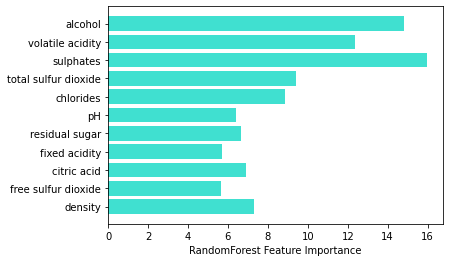

In [57]:
rs = RobustScaler()
X_train_lof_rs = rs.fit_transform(X_train_lof)
X_test_lof_rs = rs.transform(X_test_lof)

rfr = RandomForestRegressor(random_state=RANDOM_SEED)
rfr.fit(X_train_lof_rs, y_train_lof)

sorted_feature_importance = rfr.feature_importances_.argsort()
plt.barh(red.drop('quality', axis=1).columns[sorted_feature_importance], 
        cbr.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("RandomForest Feature Importance")

In [59]:
reg = RandomForestRegressor(random_state=RANDOM_SEED)

param_randomforest = [              
              {'n_estimators': Integer(100, 1001),
               'max_features': ['auto', 'sqrt'],
               'max_depth': Integer(3, 31),
               'min_samples_split': Integer(2, 11),
               'min_samples_leaf': Integer(1, 5),
               'bootstrap' : [True, False]
               }
             ]

skf = StratifiedKFold(n_splits=5,
                      shuffle=True,
                      random_state=RANDOM_SEED)

mse = make_scorer(mean_squared_error, greater_is_better=False)

opt = BayesSearchCV(reg,
                    param_randomforest,
                     scoring=mse,
                    cv=skf,
                    n_iter=100,
                    n_jobs=1,  # use just 1 job with CatBoost in order to avoid segmentation fault
                    return_train_score=False,
                    refit=True,
                    optimizer_kwargs={'base_estimator': 'GP'},
                    random_state=RANDOM_SEED,
                   verbose=0)

In [60]:
optimizer, best_params = report_perf(opt, X_train_lof_rs, y_train_lof,'RandomForest', 
                          callbacks=[VerboseCallback(100), 
                                     DeadlineStopper(60*10)])

Iteration No: 1 started. Searching for the next optimal point.
Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 9.0094
Function value obtained: 0.5059
Current minimum: 0.5059
Iteration No: 2 started. Searching for the next optimal point.
Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 1.6345
Function value obtained: 0.4056
Current minimum: 0.4056
Iteration No: 3 started. Searching for the next optimal point.
Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 4.5644
Function value obtained: 0.3991
Current minimum: 0.3991
Iteration No: 4 started. Searching for the next optimal point.
Iteration No: 4 ended. Search finished for the next optimal point.
Time taken: 2.4395
Function value obtained: 0.4035
Current minimum: 0.3991
Iteration No: 5 started. Searching for the next optimal point.
Iteration No: 5 ended. Search finished for the next optimal point.
Time taken: 14.4323
Function value obtained: 0.399

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 12.6801
Function value obtained: 0.3967
Current minimum: 0.3964
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 2.6782
Function value obtained: 0.4027
Current minimum: 0.3964
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 10.9899
Function value obtained: 0.3999
Current minimum: 0.3964
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 3.7360
Function value obtained: 0.4028
Current minimum: 0.3964
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 19.1121
Function value obtained: 0.3981
Current minimum: 0.3964
Iteration No: 46 started. 

In [61]:
best_reg_rf = RandomForestRegressor(**best_params,
                       random_state=RANDOM_SEED)

best_reg_rf.fit(X_train_lof_rs, y_train_lof)
best_pred_rf = best_reg.predict(X_test_lof_rs)

print(np.mean(np.square(best_pred_rf - y_test_lof)))

0.48410370684888615


### Result Analysis

In [62]:
df_acc_rf, acc_rf = result_analysis(best_pred_rf, y_test_lof)

print(acc_rf)
df_acc_rf

0.5687022900763359


,accuracy,mse_by_target
3,0.000000,3.817969
4,0.000000,2.082316
5,0.794643,0.216085
6,0.504854,0.328223
7,0.250000,0.960480
8,0.000000,3.210739
